
## Overview


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct
from pyspark.sql import functions as F

spark = SparkSession \
    .builder \
    .appName("Airbnb New User Bookings") \
    .getOrCreate()

spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [ ]:
# Check default parallelism
sc = spark.sparkContext
sc.defaultParallelism

Out[2]: 8

In [ ]:
spark.conf.get( "spark.sql.files.maxPartitionBytes")

Out[3]: '134217728b'

In [ ]:
#Check default number of shuffle partitions
spark.conf.get( "spark.sql.shuffle.partitions" )

Out[4]: '200'

In [ ]:
# Here we 're working with a relatively small dataset (where the data can fit into memory across the executors), we wouldn't need too many partitions. In this case, we could lower the number of partitions to reduce overhead
spark.conf.set("spark.sql.shuffle.partitions", 4)

In [ ]:
# Enable Adaptive Query Execution (AQE) in Spark to dynamically adjust shuffle partitions during execution
spark.conf.set("spark.sql.adaptive.enabled", "true")

In [ ]:
spark.conf.set("spark.sql.files.minPartitionNum", 8)

###### Processing udf

In [ ]:
from pyspark.sql.functions import col, count, when, isnan

# get null percentage
def null_percentage_analysis(df):
    print("\nNull Percentage Analysis:")
    print("-" * 40)
    total_rows = df.count()
    
    for column in df.columns:
        null_count = df.filter(col(column).isNull()).count()
        null_percent = (null_count / total_rows) * 100
        
        if null_count > 0:
            print(f"{column}: {null_count} null values ({null_percent:.2f}%)")
    
    print("-" * 40)


## Read the files

 
**There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because `'other' means there was a booking, but is to a country not included in the list`, while `'NDF' means there wasn't a booking`.**


**File descriptions**

train_users.csv - the training set of users

test_users.csv - the test set of users

* id: user id

* date_account_created: the date of account creation

* timestamp_first_active: timestamp of the first activity, `note` that it can be earlier than date_account_created or date_first_booking because a user can search before signing up

* date_first_booking: date of first booking

* gender

* age

* signup_method

* signup_flow: the page a user came to signup up from

* language: international language preference

* affiliate_channel: what kind of paid marketing

* affiliate_provider: where the marketing is e.g. google, craigslist, other

* first_affiliate_tracked: whats the first marketing the user interacted with before the signing up

* signup_app

* first_device_type

* first_browser

* country_destination: this is the target variable you are to predict

**sessions.csv - web sessions log for users**

* user_id: to be joined with the column 'id' in users table

* action

* action_type

* action_detail

* device_type

* secs_elapsed

**countries.csv - summary statistics of destination countries in this dataset and their locations**

**age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination**

**sample_submission.csv - correct format for submitting your predictions**


In [ ]:
## Add types not to infer schema but add it manually.
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType, DateType, FloatType

In [ ]:
################################ CSV files read configurations
# File location and type
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

#### 1. age_gender_bkts.csv file

In [ ]:
#############################################
## Read age_gender_bkts
#############################################
file_location = "/FileStore/tables/age_gender_bkts.csv"

age_gender_bkts_schema = StructType([
    StructField("age_bucket", StringType(), True),
    StructField("country_destination", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("population_in_thousands", FloatType(), True),
    StructField("year", FloatType(), True)
])

# The applied options are for CSV files. For other file types, these will be ignored.
age_gender_bkts = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", "true") \
  .schema(age_gender_bkts_schema) \
  .load(file_location)

print((age_gender_bkts.count(), len(age_gender_bkts.columns)))

# Get distinct count of records in a specific column (e.g., 'name')
distinct_count = age_gender_bkts.select(countDistinct("country_destination")).collect()[0][0]
print(f"Distinct count for country_destination: {distinct_count}")

distinct_count = age_gender_bkts.select(countDistinct("gender")).collect()[0][0]
print(f"Distinct count for gender: {distinct_count}")

display(age_gender_bkts.limit(10))
# age_gender_bkts.printSchema()
# age_gender_bkts.show(5)

(420, 5)
Distinct count for country_destination: 10
Distinct count for gender: 2


age_bucket,country_destination,gender,population_in_thousands,year
100+,AU,male,1.0,2015.0
95-99,AU,male,9.0,2015.0
90-94,AU,male,47.0,2015.0
85-89,AU,male,118.0,2015.0
80-84,AU,male,199.0,2015.0
75-79,AU,male,298.0,2015.0
70-74,AU,male,415.0,2015.0
65-69,AU,male,574.0,2015.0
60-64,AU,male,636.0,2015.0
55-59,AU,male,714.0,2015.0


In [ ]:
age_gender_bkts_distinct = age_gender_bkts.groupBy("country_destination").agg(
    F.sum("population_in_thousands").alias("total_population")
)
age_gender_bkts_distinct.show()

+-------------------+----------------+
|country_destination|total_population|
+-------------------+----------------+
|                 AU|         23923.0|
|                 FR|         64983.0|
|                 US|        325132.0|
|                 CA|         35871.0|
|                 IT|         61145.0|
|                 NL|         16848.0|
|                 PT|         10609.0|
|                 ES|         47203.0|
|                 DE|         82562.0|
|                 GB|         63840.0|
+-------------------+----------------+



In [ ]:
age_gender_bkts.groupBy("country_destination").count().filter("count > 1").show()

+-------------------+-----+
|country_destination|count|
+-------------------+-----+
|                 AU|   42|
|                 FR|   42|
|                 US|   42|
|                 CA|   42|
|                 IT|   42|
|                 NL|   42|
|                 PT|   42|
|                 ES|   42|
|                 DE|   42|
|                 GB|   42|
+-------------------+-----+



In [ ]:
age_gender_bkts = age_gender_bkts.repartition("gender")

In [ ]:
age_gender_bkts.groupBy("gender").count().filter("count > 1").show()

+------+-----+
|gender|count|
+------+-----+
|  male|  210|
|female|  210|
+------+-----+



**as we see it 420 instance every country take 42 which is equally distributed**

**we can join this data frame using country but we will get nulls regarding NDF which represent 58% of the train df if we use left join and lose it if we use inner join which is not acceptable**

**if we join using gender, here we have two (male,female) but at train we have unknow which represent 47% of the data. it will cause which take us to the same problem and i can't change this to any gender which will make our data more biased and why? a do not have any information to do it so?**

#### 2. Read the countries.csv file.

In [ ]:
#############################################
## Read countries
#############################################
file_location = "/FileStore/tables/countries.csv"

countries_schema = StructType([
    StructField("country_destination", StringType(), True),
    StructField("lat_destination", FloatType(), True),
    StructField("lng_destination", FloatType(), True),
    StructField("distance_km", FloatType(), True),
    StructField("destination_km2", FloatType(), True),
    StructField("destination_language", StringType(), True),
    StructField("language_levenshtein_distance", FloatType(), True)])

# The applied options are for CSV files. For other file types, these will be ignored.
countries = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", "true") \
  .schema(countries_schema) \
  .load(file_location)

print((countries.count(), len(countries.columns)))

# Get distinct count of records in a specific column (e.g., 'name')
distinct_count = countries.select(countDistinct("country_destination")).collect()[0][0]
print(f"Distinct count for country_destination: {distinct_count}")

display(countries.limit(10))
# countries.printSchema()
# countries.show(5)

(10, 7)
Distinct count for country_destination: 10


country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
AU,-26.853388,133.27516,15297.744,7741220.0,eng,0.0
CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.0
DE,51.165707,10.452764,7879.568,357022.0,deu,72.61
ES,39.896027,-2.4876945,7730.724,505370.0,spa,92.25
FR,46.232193,2.209667,7682.945,643801.0,fra,92.06
GB,54.63322,-3.4322774,6883.659,243610.0,eng,0.0
IT,41.87399,12.564167,8636.631,301340.0,ita,89.4
NL,52.133057,5.29525,7524.3203,41543.0,nld,63.22
PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
US,36.966427,-95.84403,0.0,9826675.0,eng,0.0


In [ ]:
countries.select('country_destination').distinct().orderBy('country_destination').show(11,truncate=False)

+-------------------+
|country_destination|
+-------------------+
|AU                 |
|CA                 |
|DE                 |
|ES                 |
|FR                 |
|GB                 |
|IT                 |
|NL                 |
|PT                 |
|US                 |
+-------------------+



there is no need to join this data with our train data as NDF  is nearly 57% of the train data and if we join we get most the this column as nulls as it not represented here in the countries_df so no need for it 

joining data with left join to perserve most of our data will get us this analysis 

```python
Null Percentage Analysis:
----------------------------------------
date_first_booking: 124543 null values (58.35%)
age: 87990 null values (41.22%)
first_affiliate_tracked: 6065 null values (2.84%)
lat_destination: 134637 null values (63.08%)
lng_destination: 134637 null values (63.08%)
distance_km: 134637 null values (63.08%)
destination_km2: 134637 null values (63.08%)
destination_language: 134637 null values (63.08%)
language_levenshtein_distance: 134637 null values (63.08%)
----------------------------------------
```

``` python
from pyspark.sql.functions import col, count, when, isnan

file_location = "/FileStore/tables/train_users_2.csv"

train_users_2_schema = StructType([
    StructField("id", StringType(), True),
    StructField("date_account_created", DateType(), True),
    StructField("timestamp_first_active", StringType(), True),
    StructField("date_first_booking", DateType(), True),
    StructField("gender", StringType(), True),
    StructField("age", FloatType(), True),
    StructField("signup_method", StringType(), True),
    StructField("signup_flow", FloatType(), True),
    StructField("language", StringType(), True),
    StructField("affiliate_channel", StringType(), True),
    StructField("affiliate_provider", StringType(), True),
    StructField("first_affiliate_tracked", StringType(), True),
    StructField("signup_app", StringType(), True),
    StructField("first_device_type", StringType(), True),
    StructField("first_browser", StringType(), True),
    StructField("country_destination", StringType(), True)])

# The applied options are for CSV files. For other file types, these will be ignored.
train_users_2 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", "true") \
  .schema(train_users_2_schema) \
  .load(file_location)


from pyspark.sql import functions as F


# Perform the join on country_destination
joined_df = train_users_2.join(
    countries,
    on="country_destination",
    how="left"  # Use "left" join to keep all rows from train_users_2
)


# get null percentage
def null_percentage_analysis(df):
    print("\nNull Percentage Analysis:")
    print("-" * 40)
    total_rows = df.count()
    
    for column in df.columns:
        null_count = df.filter(col(column).isNull()).count()
        null_percent = (null_count / total_rows) * 100
        
        if null_count > 0:
            print(f"{column}: {null_count} null values ({null_percent:.2f}%)")
    
    print("-" * 40)

null_percentage_analysis(joined_df)

```

###### Unpersist the countries dataframe as we won't use it in out train.

In [ ]:
countries.unpersist()

Out[18]: DataFrame[country_destination: string, lat_destination: float, lng_destination: float, distance_km: float, destination_km2: float, destination_language: string, language_levenshtein_distance: float]

#### 3. sessions.csv file.

In [ ]:
#############################################
## Read sessions
#############################################
file_location = "/FileStore/tables/sessions.csv"

sessions_schema = StructType([
    StructField("user_id", StringType(), True),
    StructField("action", StringType(), True),
    StructField("action_type", StringType(), True),
    StructField("action_detail", StringType(), True),
    StructField("device_type", StringType(), True),
    StructField("secs_elapsed", FloatType(), True)])

# The applied options are for CSV files. For other file types, these will be ignored.
sessions = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", "true") \
  .schema(sessions_schema) \
  .load(file_location)

print((sessions.count(), len(sessions.columns)))

distinct_count = sessions.select(countDistinct("user_id")).collect()[0][0]
print(f"Distinct count for user_id: {distinct_count}")

display(sessions.limit(10))
# sessions.printSchema()
# sessions.show(5)

(10567737, 6)
Distinct count for user_id: 135483


user_id,action,action_type,action_detail,device_type,secs_elapsed
d1mm9tcy42,lookup,null,null,Windows Desktop,319.0
d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
d1mm9tcy42,lookup,null,null,Windows Desktop,301.0
d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
d1mm9tcy42,lookup,null,null,Windows Desktop,435.0
d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
d1mm9tcy42,lookup,null,null,Windows Desktop,115.0
d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
d1mm9tcy42,lookup,null,null,Windows Desktop,683.0


#### 4. Read the train_users_2.csv file.

In [ ]:
#############################################
## Read train_users_2
#############################################
file_location = "/FileStore/tables/train_users_2.csv"

train_users_2_schema = StructType([
    StructField("id", StringType(), True),
    StructField("date_account_created", DateType(), True),
    StructField("timestamp_first_active", StringType(), True),
    StructField("date_first_booking", DateType(), True),
    StructField("gender", StringType(), True),
    StructField("age", FloatType(), True),
    StructField("signup_method", StringType(), True),
    StructField("signup_flow", FloatType(), True),
    StructField("language", StringType(), True),
    StructField("affiliate_channel", StringType(), True),
    StructField("affiliate_provider", StringType(), True),
    StructField("first_affiliate_tracked", StringType(), True),
    StructField("signup_app", StringType(), True),
    StructField("first_device_type", StringType(), True),
    StructField("first_browser", StringType(), True),
    StructField("country_destination", StringType(), True)])

# The applied options are for CSV files. For other file types, these will be ignored.
train_users_2 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", "true") \
  .schema(train_users_2_schema) \
  .load(file_location)

print((train_users_2.count(), len(train_users_2.columns)))

# Get distinct count of records in a specific column (e.g., 'name')
distinct_count = train_users_2.select(countDistinct("country_destination")).collect()[0][0]
print(f"Distinct count for country_destination: {distinct_count}")

distinct_count = train_users_2.select(countDistinct("id")).collect()[0][0]
print(f"Distinct count for id: {distinct_count}")

display(train_users_2.limit(10))
# train_users_2.printSchema()
# train_users_2.show(5)

(213451, 16)
Distinct count for country_destination: 12
Distinct count for id: 213451


id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
gxn3p5htnn,2010-06-28,20090319043255,null,-unknown-,null,facebook,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
820tgsjxq7,2011-05-25,20090523174809,null,MALE,38.0,facebook,0.0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3.0,en,direct,direct,untracked,Web,Windows Desktop,IE,US
bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0.0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,null,basic,0.0,en,other,other,omg,Web,Mac Desktop,Chrome,US
lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0.0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0.0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50.0,basic,0.0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
6uh8zyj2gn,2010-01-04,20100104023758,2010-01-04,-unknown-,46.0,basic,0.0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US


In [ ]:
# Check if our target label is balanced
train_users_2.groupBy("country_destination").count().show()

+-------------------+------+
|country_destination| count|
+-------------------+------+
|                 US| 62376|
|                 FR|  5023|
|                 AU|   539|
|                NDF|124543|
|                 CA|  1428|
|                 IT|  2835|
|                 PT|   217|
|                 NL|   762|
|              other| 10094|
|                 ES|  2249|
|                 GB|  2324|
|                 DE|  1061|
+-------------------+------+



#### 5. Read the test_users.csv file.

In [ ]:
#############################################
## Read test_users
#############################################
file_location = "/FileStore/tables/test_users.csv"

test_users_schema = StructType([
    StructField("id", StringType(), True),
    StructField("date_account_created", DateType(), True),
    StructField("timestamp_first_active", StringType(), True),
    StructField("date_first_booking", DateType(), True),
    StructField("gender", StringType(), True),
    StructField("age", FloatType(), True),
    StructField("signup_method", StringType(), True),
    StructField("signup_flow", FloatType(), True),
    StructField("language", StringType(), True),
    StructField("affiliate_channel", StringType(), True),
    StructField("affiliate_provider", StringType(), True),
    StructField("first_affiliate_tracked", StringType(), True),
    StructField("signup_app", StringType(), True),
    StructField("first_device_type", StringType(), True),
    StructField("first_browser", StringType(), True),
    ])

# The applied options are for CSV files. For other file types, these will be ignored.
test_users_raw = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", "true") \
  .schema(test_users_schema) \
  .load(file_location)

print((test_users_raw.count(), len(test_users_raw.columns)))

display(test_users_raw.limit(10))
# test_users.printSchema()
# test_users.show(5)

(62096, 15)


id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
5uwns89zht,2014-07-01,20140701000006,null,FEMALE,35.0,facebook,0.0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
jtl0dijy2j,2014-07-01,20140701000051,null,-unknown-,null,basic,0.0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
xx0ulgorjt,2014-07-01,20140701000148,null,-unknown-,null,basic,0.0,en,direct,direct,linked,Web,Windows Desktop,Chrome
6c6puo6ix0,2014-07-01,20140701000215,null,-unknown-,null,basic,0.0,en,direct,direct,linked,Web,Windows Desktop,IE
czqhjk3yfe,2014-07-01,20140701000305,null,-unknown-,null,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Safari
szx28ujmhf,2014-07-01,20140701000336,null,FEMALE,28.0,basic,0.0,en,sem-brand,google,omg,Web,Windows Desktop,Chrome
guenkfjcbq,2014-07-01,20140701000514,null,MALE,48.0,basic,25.0,en,direct,direct,untracked,iOS,iPhone,-unknown-
tkpq0mlugk,2014-07-01,20140701000649,null,-unknown-,null,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
3xtgd5p9dn,2014-07-01,20140701000837,null,-unknown-,null,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
md9aj22l5a,2014-07-01,20140701002245,null,-unknown-,null,basic,0.0,en,sem-non-brand,google,omg,Web,Windows Desktop,Firefox


In [ ]:
null_percentage_analysis(test_users_raw)


Null Percentage Analysis:
----------------------------------------
date_first_booking: 62096 null values (100.00%)
age: 28876 null values (46.50%)
first_affiliate_tracked: 20 null values (0.03%)
----------------------------------------


## EDA

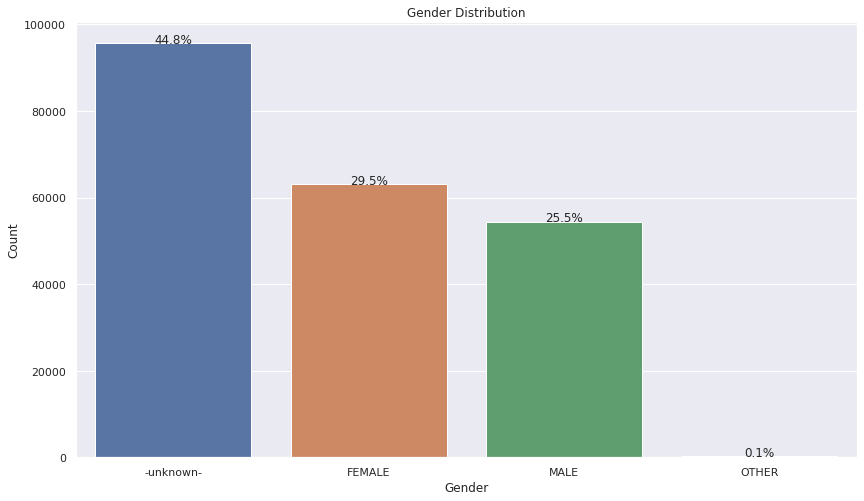

In [ ]:
from pyspark.sql.functions import count, col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute gender distribution
gender_distribution = (
    train_users_2.groupBy("gender")
    .agg(count("*").alias("count"))
    .orderBy(col("count").desc())
)

# Convert to Pandas for visualization
gender_distribution_pd = gender_distribution.toPandas()

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=gender_distribution_pd, 
    x="gender", 
    y="count", 
    order=gender_distribution_pd["gender"],
    color=sns.set()
)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution")

# Add percentages on bars
total_count = gender_distribution_pd["count"].sum()
for i, row in gender_distribution_pd.iterrows():
    percentage = f'{(row["count"] / total_count) * 100:.1f}%'
    plt.text(i, row["count"] + 0.5, percentage, ha='center')

plt.show()


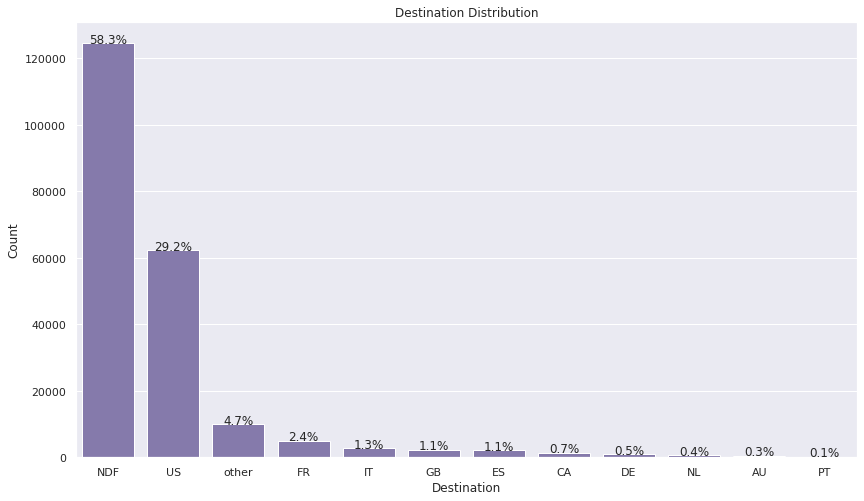

In [ ]:
# Compute destination distribution
destination_distribution = (
    train_users_2.groupBy("country_destination")
    .agg(count("*").alias("count"))
    .orderBy(col("count").desc())
)

# Convert to Pandas for visualization
destination_distribution_pd = destination_distribution.toPandas()

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=destination_distribution_pd, 
    x="country_destination", 
    y="count", 
    order=destination_distribution_pd["country_destination"], 
    color=sns.color_palette()[4]
)
plt.xlabel("Destination")
plt.ylabel("Count")
plt.title("Destination Distribution")

# Add percentages on bars
total_count = destination_distribution_pd["count"].sum()
for i, row in destination_distribution_pd.iterrows():
    percentage = f'{(row["count"] / total_count) * 100:.1f}%'
    plt.text(i, row["count"] + 0.5, percentage, ha='center')

plt.show()


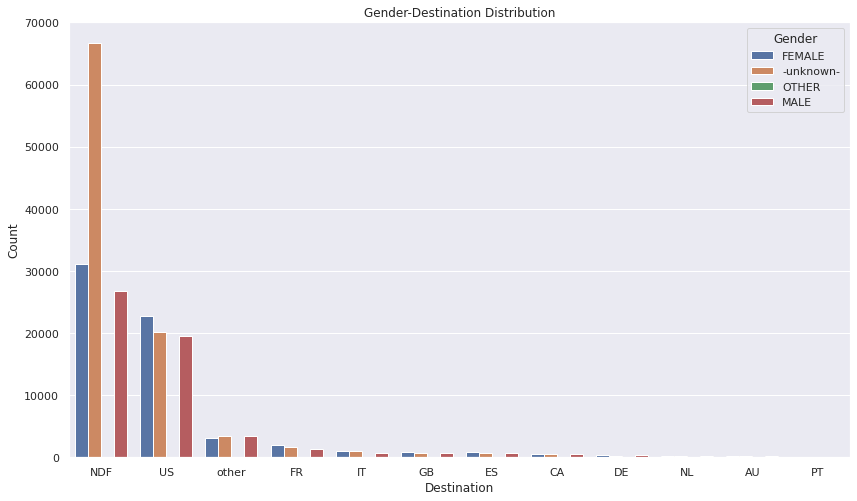

In [ ]:
# Compute gender-destination distribution
gender_destination_distribution = (
    train_users_2.groupBy("country_destination", "gender")
    .agg(count("*").alias("count"))
)

# Convert to Pandas for visualization
gender_destination_distribution_pd = gender_destination_distribution.toPandas()

# Plot
plt.figure(figsize=(14, 8))
order1 = (
    gender_destination_distribution_pd.groupby("country_destination")["count"]
    .sum()
    .sort_values(ascending=False)
    .index
)
sns.barplot(
    data=gender_destination_distribution_pd,
    x="country_destination",
    y="count",
    hue="gender",
    order=order1,
)
plt.xlabel("Destination")
plt.ylabel("Count")
plt.title("Gender-Destination Distribution")
plt.legend(title="Gender")
plt.show()


## Preprocessing data

### Data Cleaning 

#### age_gender_bkts df 

JUST TO KNOW THE MEAN AS WE USE IT TO FILL IN THE NULLS REGARDING OUR CATEGORY FUNCTION WE WILL CREATE IN THE FEATURE ENGINEERING WORK

In [ ]:
from pyspark.sql.functions import col, when, split, expr

# Add a column for the calculated age contribution
df_with_age_contribution = age_gender_bkts.withColumn(
    "age_contribution",
    when(
        col("age_bucket").contains("+"),
        100 * col("population_in_thousands")  # For age buckets with '+'
    ).otherwise(
        (
            (split(col("age_bucket"), "-")[0].cast("float") + 
             split(col("age_bucket"), "-")[1].cast("float")) / 2
        ) * col("population_in_thousands")  # For range age buckets
    )
)

# Calculate the sum of age contributions and total population
aggregates = df_with_age_contribution.agg(
    {"age_contribution": "sum", "population_in_thousands": "sum"}
).collect()

# Extract the aggregated values
sum_age_times_population_in_thousands = aggregates[0]["sum(age_contribution)"]
total_population = aggregates[0]["sum(population_in_thousands)"]

# Calculate the mean age
mean_age = sum_age_times_population_in_thousands / total_population

mean_age


Out[26]: 40.14400996563386

In [ ]:
# check the nulls
null_percentage_analysis(age_gender_bkts)


Null Percentage Analysis:
----------------------------------------
----------------------------------------


In [ ]:
# check the quality/validality of the data 
display(age_gender_bkts.describe())

summary,age_bucket,country_destination,gender,population_in_thousands,year
count,420,420,420,420,420
mean,null,null,null,1743.1333333333334,2015.0
stddev,null,null,null,2509.843202004375,0.0
min,0-4,AU,female,0.0,2015.0
max,95-99,US,male,11601.0,2015.0


In [ ]:
# check for duplicates
age_gender_bkts.count() - age_gender_bkts.dropDuplicates().count()

Out[29]: 0

###### Remove the age_gender_bkts data frame as we won't need it anymore.

In [ ]:
age_gender_bkts.unpersist()

Out[30]: DataFrame[age_bucket: string, country_destination: string, gender: string, population_in_thousands: float, year: float]

#### sessions df


When joining two DataFrames on id where one (session_df) has far more rows (10,567,737) but fewer unique id values (135,483 distinct) compared to the other (train_df) with 213,451 unique id values, you need to carefully handle the join to ensure it is efficient and produces meaningful results.

**Key Considerations:**

1.Cardinality of id:

session_df has fewer distinct id values, meaning some ids repeat many times.
train_df has distinct id values (one-to-one mapping for id).

2.Join Type:

The type of join depends on your goal. Typically, a left join or inner join is appropriate.

3.Handling Duplicates:

Since session_df has repeated ids, the resulting join will produce multiple rows for each match.

4.Optimizing Performance:

Consider reducing the size of session_df before joining if feasible, using filters or aggregations.


there will be NULLs in the result of your join if the id (or user_id) in train has no corresponding match in the aggregated sessions DataFrame. Here's why:


**Why NULLs Occur in Joins**

1.Left Join:

A left join ensures that all rows from train are preserved, even if there is no matching id in the aggregated sessions DataFrame.
For ids in train that are not present in the sessions DataFrame, the sum_secs_elapsed column will have NULL values.

2.Inner Join:

An inner join will only include rows where there is a match in both train and the aggregated sessions DataFrame. If an id in train is not present in sessions, it will be excluded.

Inner Join: will reduce our resulting data to 135,483 intead of orignal 213,451

In [ ]:
# check the nulls
null_percentage_analysis(sessions)


Null Percentage Analysis:
----------------------------------------
user_id: 34496 null values (0.33%)
action: 79626 null values (0.75%)
action_type: 1126204 null values (10.66%)
action_detail: 1126204 null values (10.66%)
secs_elapsed: 136031 null values (1.29%)
----------------------------------------


In [ ]:
# check the quality/validality of the data 
display(sessions.describe())

summary,user_id,action,action_type,action_detail,device_type,secs_elapsed
count,10533241,10488111,9441533,9441533,10567737,10431706
mean,null,11.445711108021687,null,null,null,19405.81075070559
stddev,null,1.7023772142506777,null,null,null,88884.24320857166
min,00023iyk9l,10,-unknown-,-unknown-,-unknown-,0.0
max,zzzlylp57e,zendesk_login_jwt,view,your_trips,iPodtouch,1799977.0


In [ ]:
# check for duplicates
sessions.count() - sessions.dropDuplicates().count()

Out[33]: 252536

**Many-to-One Join (Aggregating session_df)**

In [ ]:
from pyspark.sql.functions import sum as pyspark_sum
from pyspark.sql import functions as F

# total_session_time = sessions.groupby("user_id").agg(pyspark_sum('secs_elapsed').alias('sum_secs_elapsed'))

total_session_time_1 = sessions.groupby("user_id").agg(
    F.sum("secs_elapsed").alias("sum_secs_elapsed")
)

total_session_time_1.count()

Out[22]: 135484

###### Unpersist the sessions dataframe as we won't use it in out train.

In [ ]:
sessions.unpersist()

Out[35]: DataFrame[user_id: string, action: string, action_type: string, action_detail: string, device_type: string, secs_elapsed: float]

#### train df

In [ ]:
# check the nulls
null_percentage_analysis(train_users_2)


Null Percentage Analysis:
----------------------------------------
date_first_booking: 124543 null values (58.35%)
age: 87990 null values (41.22%)
first_affiliate_tracked: 6065 null values (2.84%)
----------------------------------------


In [ ]:
# check the quality/validality of the data 
display(train_users_2.describe())

summary,id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,213451,213451,213451,125461,213451,213451,213451,213451,213451,207386,213451,213451,213451,213451
mean,null,2.0130850417367293E13,null,49.66833517985669,null,3.2673868944160485,null,null,null,null,null,null,null,null
stddev,null,9.253717046551546E9,null,155.66661183021515,null,7.63770686943509,null,null,null,null,null,null,null,null
min,00023iyk9l,20090319043255,-unknown-,1.0,basic,0.0,ca,api,baidu,linked,Android,Android Phone,-unknown-,AU
max,zzzlylp57e,20140630235824,OTHER,2014.0,google,25.0,zh,seo,yandex,untracked,iOS,iPhone,wOSBrowser,other


In [ ]:
# check for duplicates
train_users_2.count() - train_users_2.dropDuplicates().count()

Out[38]: 0

let's see how mant labels each categorical feature have as we will do encoding later and we don't want our feature to be too much at the end of the day

In [ ]:
categorical_cols = ['gender', 'signup_method', 'language', 
                    'affiliate_channel', 'affiliate_provider', 
                    'first_affiliate_tracked', 'signup_app', 
                    'first_device_type', 'first_browser']

numeric_cols = ['age', 'signup_flow']

train_users_2.select('signup_method').distinct().show(50,truncate=False)
train_users_2.select('language').distinct().show(50,truncate=False)
train_users_2.select('affiliate_channel').distinct().show(50,truncate=False)
train_users_2.select('affiliate_provider').distinct().show(50,truncate=False)
train_users_2.select('first_affiliate_tracked').distinct().show(50,truncate=False)
train_users_2.select('signup_app').distinct().show(50,truncate=False)
train_users_2.select('first_device_type').distinct().show(50,truncate=False)
train_users_2.select('gender').distinct().show(50,truncate=False)
train_users_2.select('first_browser').distinct().show(55,truncate=False)


+-------------+
|signup_method|
+-------------+
|facebook     |
|basic        |
|google       |
+-------------+

+--------+
|language|
+--------+
|pt      |
|ko      |
|ru      |
|tr      |
|fr      |
|de      |
|ja      |
|el      |
|da      |
|id      |
|th      |
|es      |
|pl      |
|hu      |
|fi      |
|no      |
|en      |
|it      |
|zh      |
|sv      |
|nl      |
|cs      |
|ca      |
|hr      |
|is      |
+--------+

+-----------------+
|affiliate_channel|
+-----------------+
|direct           |
|api              |
|seo              |
|remarketing      |
|other            |
|sem-brand        |
|sem-non-brand    |
|content          |
+-----------------+

+-------------------+
|affiliate_provider |
+-------------------+
|direct             |
|google             |
|bing               |
|craigslist         |
|facebook           |
|vast               |
|meetup             |
|facebook-open-graph|
|email-marketing    |
|other              |
|gsp                |
|yahoo            

In [ ]:
print(f"first_browser feature label count: {train_users_2.select('first_browser').distinct().count()}")
print(f"signup_method feature label count: {train_users_2.select('signup_method').distinct().count()}")
print(f"gender feature label count: {train_users_2.select('gender').distinct().count()}")
print(f"language feature label count: {train_users_2.select('language').distinct().count()}")
print(f"affiliate_channel feature label count: {train_users_2.select('affiliate_channel').distinct().count()}")
print(f"affiliate_provider feature label count: {train_users_2.select('affiliate_provider').distinct().count()}")
print(f"first_affiliate_tracked feature label count: {train_users_2.select('first_affiliate_tracked').distinct().count()}")
print(f"signup_app feature label count: {train_users_2.select('signup_app').distinct().count()}")
print(f"first_device_type feature label count: {train_users_2.select('first_device_type').distinct().count()}")


first_browser feature label count: 52
signup_method feature label count: 3
gender feature label count: 4
language feature label count: 25
affiliate_channel feature label count: 8
affiliate_provider feature label count: 18
first_affiliate_tracked feature label count: 8
signup_app feature label count: 4
first_device_type feature label count: 9


**let's perform the join with session df elapesd feature as its thev only feature we are interested in**

In [ ]:
# Left join
new_train_users = train_users_2.join(total_session_time_1, train_users_2.id == total_session_time_1.user_id, how="left")

In [ ]:
display(new_train_users.limit(5))

id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,user_id,sum_secs_elapsed
bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0.0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,null,null
4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3.0,en,direct,direct,untracked,Web,Windows Desktop,IE,US,null,null
87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,null,null
gxn3p5htnn,2010-06-28,20090319043255,null,-unknown-,null,facebook,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,null,null
820tgsjxq7,2011-05-25,20090523174809,null,MALE,38.0,facebook,0.0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,null,null


In [ ]:
new_train_users = new_train_users.drop("user_id")

In [ ]:
null_percentage_analysis(new_train_users)


Null Percentage Analysis:
----------------------------------------
date_first_booking: 124543 null values (58.35%)
age: 87990 null values (41.22%)
first_affiliate_tracked: 6065 null values (2.84%)
sum_secs_elapsed: 140820 null values (65.97%)
----------------------------------------


**assume a missing id in sessions implies no session activity so, replace NULL with 0**

**we will drop date_first_booking feature**


#### test df

In [ ]:
# check the nulls
null_percentage_analysis(test_users_raw)


Null Percentage Analysis:
----------------------------------------
date_first_booking: 62096 null values (100.00%)
age: 28876 null values (46.50%)
first_affiliate_tracked: 20 null values (0.03%)
----------------------------------------


In [ ]:
# check the quality/validality of the data 
display(test_users_raw.describe())

summary,id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
count,62096,62096,62096,33220,62096,62096,62096,62096,62096,62076,62096,62096,62096
mean,null,2.014081168521807E13,null,37.61667670078266,null,7.813884952331874,null,null,null,null,null,null,null
stddev,null,8.024585266739331E7,null,74.44064668390018,null,11.2542905496407,null,null,null,null,null,null,null
min,0010k6l0om,20140701000006,-unknown-,1.0,basic,0.0,-unknown-,content,baidu,linked,Android,Android Phone,-unknown-
max,zzxox7jnrx,20140930235901,OTHER,2002.0,weibo,25.0,zh,seo,yandex,untracked,iOS,iPhone,wOSBrowser


In [ ]:
# check for duplicates
test_users_raw.count() - test_users_raw.dropDuplicates().count()

Out[47]: 0

In [ ]:
print((test_users_raw.count(), len(test_users_raw.columns)))

# Get distinct count of records in a specific column (e.g., 'name')
distinct_count = test_users_raw.select(countDistinct("id")).collect()[0][0]
print(f"Distinct count for id: {distinct_count}")


(62096, 15)
Distinct count for id: 62096


**let's perform the join with session df elapesd feature as its thev only feature we are interested in**

**we here has 62096 row user id for test data vs 135483 rows in session df with 34496 nulls.**

**use inner join to Remove null user IDs from session DataFrame as it only get matched rows, Effectively give you test instances with corresponding session data**


In [ ]:
# Inner join on user ID, dropping nulls from session DataFrame first
test_users_raw = test_users_raw.join(total_session_time_1.dropna(subset=['user_id']), test_users_raw.id == total_session_time_1.user_id, how='inner')

In [ ]:
display(test_users_raw.limit(5))

id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,user_id,sum_secs_elapsed
czqhjk3yfe,2014-07-01,20140701000305,null,-unknown-,null,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Safari,czqhjk3yfe,454023.0
3xtgd5p9dn,2014-07-01,20140701000837,null,-unknown-,null,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,3xtgd5p9dn,8481847.0
md9aj22l5a,2014-07-01,20140701002245,null,-unknown-,null,basic,0.0,en,sem-non-brand,google,omg,Web,Windows Desktop,Firefox,md9aj22l5a,5084265.0
fyomoivygn,2014-07-01,20140701002531,null,FEMALE,30.0,basic,25.0,en,direct,direct,untracked,iOS,iPhone,-unknown-,fyomoivygn,157911.0
glck7hlmzz,2014-07-01,20140701004259,null,-unknown-,null,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,glck7hlmzz,662916.0


In [ ]:
test_users_raw = test_users_raw.drop("user_id")

In [ ]:
null_percentage_analysis(test_users_raw)


Null Percentage Analysis:
----------------------------------------
date_first_booking: 61668 null values (100.00%)
age: 28601 null values (46.38%)
first_affiliate_tracked: 6 null values (0.01%)
sum_secs_elapsed: 242 null values (0.39%)
----------------------------------------


**date_first_booking will be removed in feature engineering process and age will be fill as train in feature engineering process too**

**for first_affiliate_tracked and sum_secs_elapsed we can dropna safely as our data here is mostly safe ratio to be removed**

In [ ]:
print((test_users_raw.count(), len(test_users_raw.columns)))

# Get distinct count of records in a specific column (e.g., 'name')
distinct_count = test_users_raw.select(countDistinct("id")).collect()[0][0]
print(f"Distinct count for id: {distinct_count}")


(61668, 16)
Distinct count for id: 61668


In [ ]:
# check for duplicates
test_users_raw.count() - test_users_raw.dropDuplicates().count()

Out[54]: 0

### Feature Engineering 

In [ ]:
# UDFs for feature engineering
from pyspark.sql.functions import udf

# we may not use this fun 
def extract_year(date_str):
    return int(date_str.split('-')[0]) if date_str else -1

def extract_month(date_str):
    return int(date_str.split('-')[1]) if date_str else -1

def extract_day(date_str):
    return int(date_str.split('-')[2]) if date_str else -1


# for timestamp feature handling
import datetime

def process_timestamp(timestamp_val):
    # Handle different input types
    if timestamp_val is None:
        return [-1, -1, -1]
    
    # If it's already an integer, convert to string first
    if isinstance(timestamp_val, int):
        timestamp_str = str(timestamp_val).zfill(14)  # Ensure 14 digits
    elif isinstance(timestamp_val, str):
        timestamp_str = timestamp_val.zfill(14)  # Ensure 14 digits
    elif isinstance(timestamp_val, datetime.datetime):
        # If it's a datetime object, extract components
        return [
            timestamp_val.year,
            timestamp_val.month,
            timestamp_val.day
        ]
    else:
        return [-1, -1, -1]
    
    try:
        return [
            int(timestamp_str[:4]),   # year
            int(timestamp_str[4:6]),  # month
            int(timestamp_str[6:8])   # day
        ]
    except (ValueError, IndexError):
        return [-1, -1, -1]


def age_corrector(age):
    if age is None:
        return "Millennials"
    try:
        age = float(age)
        if age >= 14 and age < 28:
            return "Gen Z"
        elif age >= 28 and age < 44:
            return "Millennials"
        elif age >= 44 and age < 60:
            return "Gen X"
        elif age >= 60 and age <= 75:
            return "The Baby Boomer Generation"
        elif age > 1940 and age < 2001:  # Assuming year of birth
            return age_corrector(2015.0 - age)
        else:
            return "Millennials" # This should be age_corrector(mean_age), but as we know it's "Millennials" we would return it directly.
    except:
        return "Millennials"
    
# Register UDFs

extract_year_udf = udf(extract_year, IntegerType())
extract_month_udf = udf(extract_month, IntegerType())
extract_day_udf = udf(extract_day, IntegerType())
process_timestamp_udf = udf(process_timestamp, ArrayType(IntegerType()))
correct_age = udf(age_corrector, StringType())


In [ ]:
from pyspark.ml.feature import PCA
from pyspark.sql.functions import col

def select_pca_components(df, feature_col="features", variance_threshold=0.95):
    """
    Dynamically compute the minimum number of PCA components to explain the specified variance.

    Args:
        df (DataFrame): Input DataFrame containing the feature column.
        feature_col (str): Name of the column containing feature vectors.
        variance_threshold (float): Cumulative variance threshold (default is 0.95).

    Returns:
        int: Minimum number of components required to explain the variance threshold.
    """

    # Check the size of feature vectors
    first_row = df.select(feature_col).first()
    vector_size = first_row[feature_col].size if first_row else 0

    if vector_size == 0:
        raise ValueError("Feature vector size cannot be zero. Ensure the input column is correctly assembled.")

    # Fit PCA model to determine explained variance
    pca = PCA(k=vector_size, inputCol=feature_col, outputCol="pca_temp")
    model = pca.fit(df)
    
    # Compute cumulative variance
    explained_variance_ratios = model.explainedVariance.toArray()
    cumulative_variance = 0
    num_components = 0

    for ratio in explained_variance_ratios:
        cumulative_variance += ratio
        num_components += 1
        if cumulative_variance >= variance_threshold:
            break

    return num_components


#### Process Test

In [ ]:
from pyspark.sql.functions import lower, col
from pyspark.sql.functions import year, month, dayofmonth, to_date
from pyspark.sql.functions import lower, col, year, month, dayofmonth, when, lit

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Feature Engineering
def preprocess_test_data(df):    
    

    # Drop unnecessary columns
    df = df.drop('id', 'date_first_booking')
    
    # we can drop NAs in the first_affiliate_tracked feature as it's represent only few % of the data.  
    df = df.dropna(subset=["first_affiliate_tracked", "sum_secs_elapsed"])

    # fill any rest with 0
    df = df.fillna(40, subset=['age'])
    df = df.fillna(0, subset=['sum_secs_elapsed'])
    df = df.fillna(0, subset=['signup_flow'])
    df = df.fillna(0)

    # Instead of custom UDFs, use Spark's date functions
    df = df.withColumn('dac_year', year(col('date_account_created'))) \
        .withColumn('dac_month', month(col('date_account_created'))) \
        .withColumn('dac_day', dayofmonth(col('date_account_created'))) \
        .drop('date_account_created')

    ''' df = df.withColumn('dac_year', extract_year_udf(col('date_account_created'))) \
           .withColumn('dac_month', extract_month_udf(col('date_account_created'))) \
           .withColumn('dac_day', extract_day_udf(col('date_account_created'))) \
           .drop('date_account_created')
     '''

    # Timestamp first active processing
    df = df.withColumn('tfa_processing', process_timestamp_udf(col('timestamp_first_active'))) \
           .withColumn('tfa_year', col('tfa_processing')[0]) \
           .withColumn('tfa_month', col('tfa_processing')[1]) \
           .withColumn('tfa_day', col('tfa_processing')[2]) \
           .drop('timestamp_first_active', 'tfa_processing')

    # Age processing
    df = df.withColumn('age', 
        when((col('age') < 14) | (col('age') > 100), 0)
        .otherwise(col('age'))
        )
    
    
    ## converting gender to lower case
    df = df.withColumn("gender", lower(col('gender')))

    # Categorical feature encoding
    categorical_cols = ['Generation','gender', 'signup_method', 'language', 
                        'affiliate_channel', 'affiliate_provider', 
                        'first_affiliate_tracked', 'signup_app', 
                        'first_device_type', 'first_browser']
    
    numeric_cols = ['age', 'signup_flow','dac_year', 'dac_month', 'dac_day', 
                    'tfa_year', 'tfa_month', 'tfa_day', 'sum_secs_elapsed']
    
    
    ''' 
    # Replace null values in categorical columns with "Unknown"
    for c in categorical_cols:
        df = df.withColumn(c, when(col(c).isNull(), lit("Unknown")).otherwise(col(c)))
    
    '''
    
    # String Indexing for categorical columns
    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid="keep")
        for c in categorical_cols
    ]
    
    # One-Hot Encoding
    encoders = [
        OneHotEncoder(inputCols=[f"{c}_indexed" for c in categorical_cols],
                      outputCols=[f"{c}_encoded" for c in categorical_cols])
    ]
    
    # Assembling features
    feature_cols = [f"{c}_encoded" for c in categorical_cols] + numeric_cols
    
    assembler = VectorAssembler(
        inputCols=feature_cols, 
        outputCol="features", 
        handleInvalid="keep"  
    )
    
    ''' # Dynamically determine the number of PCA components
    assembled_df = assembler.transform(df)  # Assemble features for dynamic PCA computation
    num_pca_components = select_pca_components(assembled_df, feature_col="features", variance_threshold=0.95)
    
    # PCA stage
    pca = PCA(k=num_pca_components, inputCol="features", outputCol="pca_features")
     '''

    # Scale the features
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

    # Combine all stages into a pipeline
    stages = indexers + encoders + [assembler, scaler]


    # Create and apply pipeline
    pipeline = Pipeline(stages=stages)
    
    return pipeline.fit(df).transform(df)


In [ ]:
test_users_raw = test_users_raw.withColumn("Generation", correct_age(test_users_raw['age']))
display(test_users_raw.limit(10))

id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,sum_secs_elapsed,Generation
czqhjk3yfe,2014-07-01,20140701000305,null,-unknown-,null,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Safari,454023.0,Millennials
3xtgd5p9dn,2014-07-01,20140701000837,null,-unknown-,null,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,8481847.0,Millennials
md9aj22l5a,2014-07-01,20140701002245,null,-unknown-,null,basic,0.0,en,sem-non-brand,google,omg,Web,Windows Desktop,Firefox,5084265.0,Millennials
fyomoivygn,2014-07-01,20140701002531,null,FEMALE,30.0,basic,25.0,en,direct,direct,untracked,iOS,iPhone,-unknown-,157911.0,Millennials
glck7hlmzz,2014-07-01,20140701004259,null,-unknown-,null,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,662916.0,Millennials
f6wueq1ccn,2014-07-01,20140701004359,null,-unknown-,null,basic,0.0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,14101.0,Millennials
d45nngmojp,2014-07-01,20140701004817,null,-unknown-,27.0,basic,0.0,en,direct,direct,product,Web,Mac Desktop,Chrome,1422903.0,Gen Z
2016g8ddq0,2014-07-01,20140701005443,null,-unknown-,null,basic,0.0,en,seo,facebook,linked,Web,Windows Desktop,Chrome,337213.0,Millennials
0cvk7jktso,2014-07-01,20140701010635,null,FEMALE,36.0,basic,0.0,en,direct,direct,linked,Web,Mac Desktop,Chrome,797584.0,Millennials
vuwfq20pw3,2014-07-01,20140701010759,null,FEMALE,35.0,basic,0.0,en,direct,direct,untracked,Web,Android Phone,Android Browser,1411426.0,Millennials


In [ ]:
processed_test_users_raw = preprocess_test_data(test_users_raw)
display(processed_test_users_raw.limit(10))

gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,sum_secs_elapsed,Generation,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,Generation_indexed,gender_indexed,signup_method_indexed,language_indexed,affiliate_channel_indexed,affiliate_provider_indexed,first_affiliate_tracked_indexed,signup_app_indexed,first_device_type_indexed,first_browser_indexed,Generation_encoded,gender_encoded,signup_method_encoded,language_encoded,affiliate_channel_encoded,affiliate_provider_encoded,first_affiliate_tracked_encoded,signup_app_encoded,first_device_type_encoded,first_browser_encoded,features,scaled_features
-unknown-,0.0,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Safari,454023.0,Millennials,2014,7,1,2014,7,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 24, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 17, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 9, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 31, indices -> List(3), values -> List(1.0))","Map(vectorType -> sparse, length -> 120, indices -> List(0, 4, 8, 12, 36, 43, 60, 67, 72, 83, 113, 114, 115, 116, 117, 118, 119), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2014.0, 7.0, 1.0, 2014.0, 7.0, 1.0, 454023.0))","Map(vectorType -> dense, length -> 120, values -> List(0.5958045655314564, -0.44864642367405305, -0.2837172210243723, -0.1425911380086525, 0.9169607798304473, -0.5524250329490987, -0.5343530979102203, -0.028826798644369375, 0.6087311300160552, -0.560980837216796, -0.17778626738376846, -0.01892866926355151, 0.219850589274985, -0.12799027878420416, -0.07688906029883949, -0.07338294441437695, -0.06456607921010102, -0.06289206608203741, -0.04405807715337099, -0.04405807715337099, -0.04368555978681013, -0.036561833370320096, -0.0296632561020448, -0.024216396019218437, -0.02135546235441271, -0.01849331867327724, -0.018047484081214364, -0.01663855172845151, -0.01663855172845151, -0.01067590550046116, -0.009883887429212703, -0.009883887429212703, -0.006988793139035462, -0.004034915906823382, -0.004034915906823382, -0.004034915906823382, 0.6458061137182908, -0.4491176381068804, -0.31793818150385306, -0.14187630019002234, -0.09746483147295756, -0.05283654156463461, -0.05236972983375341, 0.6458061137182908, -0.5468505554166361, -0.16871360986534567, -0.1513207691979515, -0.08856076763636457, -0.05062167690679935, -0.04118277456029769, -0.03304496883797669, -0.01849331867327724, -0.013978610472985471, -0.013383391630294216, -0.008070028895981391, -0.006988793139035462, -0.005706279250081865, -0.005706279250081865, -0.004034915906823382, -0.004034915906823382, 0.9107810568209564, -0.58416984429136, -0.46108105708325564, -0.1139248744731164, -0.08976654169020765, -0.04779588130092973, -0.023877494002286583, 0.8182856624008072, -0.5789560204021322, -0.2977149568699414, -0.27136649193076384, -0.66517422405688, 1.6442951634222356, -0.5449411849790564, -0.3463768112798403, -0.2521552684429532, -0.11458293946056533, -0.0878107832192938, -0.07029180743645222, -0.04312079648566373, -0.616824182679738, -0.5602033111467297, -0.4475986947073832, 2.571035914217359, -0.2959941926573556, -0.2507279884399495, -0.17807841465440408, -0.1086776487237805, -0.036337915301834764, -0.027965419010415153, -0.025527154406826257, -0.024216396019218437, -0.022830693305287888,

#### Process Train

In [ ]:
from pyspark.sql.functions import lower, col
from pyspark.sql.functions import year, month, dayofmonth, to_date
from pyspark.sql.functions import lower, col, year, month, dayofmonth, when, lit

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA

# Feature Engineering
def preprocess_train_data(df):    
    

    # Drop unnecessary columns
    df = df.drop('id', 'date_first_booking')
    
    # we can drop NAs in the first_affiliate_tracked feature as it's represent only few % of the data.  
    df = df.dropna(subset=["first_affiliate_tracked"])

    # fill any rest with 0
    df = df.fillna(0, subset=['age'])
    df = df.fillna(0, subset=['sum_secs_elapsed'])
    df = df.fillna(0, subset=['signup_flow'])
    df = df.fillna(0)

    # Instead of custom UDFs, use Spark's date functions
    df = df.withColumn('dac_year', year(col('date_account_created'))) \
        .withColumn('dac_month', month(col('date_account_created'))) \
        .withColumn('dac_day', dayofmonth(col('date_account_created'))) \
        .drop('date_account_created')

    ''' df = df.withColumn('dac_year', extract_year_udf(col('date_account_created'))) \
           .withColumn('dac_month', extract_month_udf(col('date_account_created'))) \
           .withColumn('dac_day', extract_day_udf(col('date_account_created'))) \
           .drop('date_account_created')
     '''

    # Timestamp first active processing
    df = df.withColumn('tfa_processing', process_timestamp_udf(col('timestamp_first_active'))) \
           .withColumn('tfa_year', col('tfa_processing')[0]) \
           .withColumn('tfa_month', col('tfa_processing')[1]) \
           .withColumn('tfa_day', col('tfa_processing')[2]) \
           .drop('timestamp_first_active', 'tfa_processing')

    # Age processing
    df = df.withColumn('age', 
        when((col('age') < 14) | (col('age') > 100), 0)
        .otherwise(col('age'))
        )
    
    
    ## converting gender to lower case
    df = df.withColumn("gender", lower(col('gender')))

    # Categorical feature encoding
    categorical_cols = ['Generation','gender', 'signup_method', 'language', 
                        'affiliate_channel', 'affiliate_provider', 
                        'first_affiliate_tracked', 'signup_app', 
                        'first_device_type', 'first_browser']
    
    numeric_cols = ['age', 'signup_flow','dac_year', 'dac_month', 'dac_day', 
                    'tfa_year', 'tfa_month', 'tfa_day', 'sum_secs_elapsed']
    
    
    ''' 
    # Replace null values in categorical columns with "Unknown"
    for c in categorical_cols:
        df = df.withColumn(c, when(col(c).isNull(), lit("Unknown")).otherwise(col(c)))
    
    '''
    
    # String Indexing for categorical columns
    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid="keep")
        for c in categorical_cols
    ]
    
    # One-Hot Encoding
    encoders = [
        OneHotEncoder(inputCols=[f"{c}_indexed" for c in categorical_cols],
                      outputCols=[f"{c}_encoded" for c in categorical_cols])
    ]
    
    # Assembling features
    feature_cols = [f"{c}_encoded" for c in categorical_cols] + numeric_cols
    
    assembler = VectorAssembler(
        inputCols=feature_cols, 
        outputCol="features", 
        handleInvalid="keep"  
    )

    
    ''' # Dynamically determine the number of PCA components
    assembled_df = assembler.transform(df)  # Assemble features for dynamic PCA computation
    num_pca_components = select_pca_components(assembled_df, feature_col="features", variance_threshold=0.95)
    
    # PCA stage
    pca = PCA(k=num_pca_components, inputCol="features", outputCol="pca_features")
     '''

    # Scale the features
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

    # Combine all stages into a pipeline
    stages = indexers + encoders + [assembler, scaler]

    
    # Label Indexing for training data

    label_indexer = StringIndexer(
        inputCol='country_destination', 
        outputCol='label', 
        handleInvalid="keep"
        )
    
    stages.append(label_indexer)

    # Create and apply pipeline
    pipeline = Pipeline(stages=stages)
    
    return pipeline.fit(df).transform(df)


In [ ]:
new_train_users = new_train_users.withColumn("Generation", correct_age(new_train_users['age']))
display(new_train_users.limit(10))

id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,sum_secs_elapsed,Generation
bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0.0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,null,Millennials
4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3.0,en,direct,direct,untracked,Web,Windows Desktop,IE,US,null,Gen X
87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,null,Millennials
0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0.0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,null,Gen X
6uh8zyj2gn,2010-01-04,20100104023758,2010-01-04,-unknown-,46.0,basic,0.0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US,null,Gen X
gxn3p5htnn,2010-06-28,20090319043255,null,-unknown-,null,facebook,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,null,Millennials
820tgsjxq7,2011-05-25,20090523174809,null,MALE,38.0,facebook,0.0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,null,Millennials
osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,null,basic,0.0,en,other,other,omg,Web,Mac Desktop,Chrome,US,null,Millennials
lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0.0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,null,Gen X
a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50.0,basic,0.0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,null,Gen X


In [ ]:
processed_train_users = preprocess_train_data(new_train_users)
display(processed_train_users.limit(10))

gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,sum_secs_elapsed,Generation,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,Generation_indexed,gender_indexed,signup_method_indexed,language_indexed,affiliate_channel_indexed,affiliate_provider_indexed,first_affiliate_tracked_indexed,signup_app_indexed,first_device_type_indexed,first_browser_indexed,Generation_encoded,gender_encoded,signup_method_encoded,language_encoded,affiliate_channel_encoded,affiliate_provider_encoded,first_affiliate_tracked_encoded,signup_app_encoded,first_device_type_encoded,first_browser_encoded,features,scaled_features,label
female,33.0,basic,0.0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,CA,0.0,Millennials,2010,1,7,2010,1,7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 25, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 8, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 18, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 9, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 52, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 143, indices -> List(0, 5, 8, 11, 36, 44, 62, 69, 74, 82, 134, 136, 137, 138, 139, 140, 141), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 33.0, 2010.0, 1.0, 7.0, 2010.0, 1.0, 7.0))","Map(vectorType -> dense, length -> 143, values -> List(0.5817624043652915, -0.3758924215152353, -0.33355929199303225, -0.17263723318900076, -0.8910365624533463, 1.5317021593452225, -0.588489350971012, -0.036637253839392356, 0.6312277605231977, -0.6271511636462, -0.05137809645501331, 0.18650109360693654, -0.08814835596979276, -0.07464069523339624, -0.0656875455939668, -0.05910648542987524, -0.05881826414722645, -0.04866547265717839, -0.04278839951599224, -0.03368134043187896, -0.032882733635845575, -0.024261459910594415, -0.02140772573952276, -0.017431930486119757, -0.01672568720501829, -0.016138481335726006, -0.01242274965311342, -0.012028217622163738, -0.010758209253262555, -0.010531669874649327, -0.010300151497789, -0.0093167477239189, -0.008216519923069777, -0.004910203289700679, -0.004910203289700679, -0.0031054627720520827, 0.7386402719956033, -0.3768275413275841, -0.3085537995178709, -0.206160057184522, -0.2047324201719437, -0.1970158949846127, -0.13638254335306535, -0.07160819100689562, 0.7405438308273482, -0.5670474952829226, -0.24682478530820082, -0.12094790520347767, -0.1049880663570411, -0.10357052314165702, -0.06096709279360929, -0.060326340605622995, -0.05133090127011119, -0.04896322794876096, -0.04678785948591628, -0.04093903577627279, -0.028046183858346507, -0.015836724494869347, -0.01182601978944856, -0.009054229467814808, -0.006211015392795253, -0.0021958884905895347, 0.9479338056896838, -0.5360212997700335, -0.5188061292743009, -0.17490486713906414, -0.08694596104072302, -0.025897761483657432, -0.0128051390002118, 0.4036174137526942, -0.30708003782596177, -0.16951689669769493, -0.16331994000519806, -0.8721799948117714, 1.3608786241713375, -0.33351466105160454, -0.2725378696370019, -0.15064524129368506, -0.11705116226684367, -0.07917672528742477, -0.07625668196924616, -0.019146774535861742, 1.4994206616409407, -0.5276804546098756, -0.44013417419120116, -0.3374463860927781, -0.3362661882241961, -0.3200933338874348, -0.07849553621733724, -0.06418993020643722, -0.034391329163054235, -0.030122089740587

-----------------------------------------------------------------------------------------

## Save processed data as parquet file

In [ ]:
# Save as Parquet for optimized storage and faster querying
processed_train_users.write.parquet("/dbfs/mnt/data/optimized_train_df.parquet", mode="overwrite")
processed_test_users_raw.write.parquet("/dbfs/mnt/data/optimized_test_df.parquet", mode="overwrite")


In [ ]:
# To read from Parquet
processed_train_users = spark.read.parquet("/dbfs/mnt/data/optimized_train_df.parquet")
processed_test_users_raw = spark.read.parquet("/dbfs/mnt/data/optimized_test_df.parquet")

# Show schema 
processed_train_users.printSchema()
processed_test_users_raw.printSchema()


root
 |-- gender: string (nullable = true)
 |-- age: float (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: float (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- sum_secs_elapsed: double (nullable = true)
 |-- Generation: string (nullable = true)
 |-- dac_year: integer (nullable = true)
 |-- dac_month: integer (nullable = true)
 |-- dac_day: integer (nullable = true)
 |-- tfa_year: integer (nullable = true)
 |-- tfa_month: integer (nullable = true)
 |-- tfa_day: integer (nullable = true)
 |-- Generation_indexed: double (nullable = true)
 |-- gender_indexed: double (nullable = true)
 |-- signup_method_inde

## Trainging the Model

#### RandomForest Classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, expr, arrays_zip, desc
import pandas as pd

In [ ]:
# Train RandomForest
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", 
                             numTrees=100, maxDepth=4)

# Fit the model, this will inside the fun 
model = rf.fit(processed_train_users)

# Get feature importances
feature_importance_df = model.featureImportances

In [ ]:
# Convert to Pandas DataFrame
pandas_feature_importance = pd.DataFrame(
    list(enumerate(feature_importance_df.toArray())), 
    columns=['feature_index', 'importance']
)
display(pandas_feature_importance)
print(f"Total feature importance: {pandas_feature_importance.sum()}")


feature_index,importance
0,0.10282086826051834
1,0.03672201606758878
2,0.01772654210287805
3,0.0030943830088390684
4,0.1267660516548639
5,0.024448161583968092
6,0.03477745755667136
7,1.6314780772320824E-4
8,0.0457220809589154
9,0.051965724287481516


Total feature importance: feature_index    10153.0
importance           1.0
dtype: float64


In [ ]:
# Print out all metadata to understand the structure
print(processed_train_users.schema["features"].metadata)

{'ml_attr': {'attrs': {'numeric': [{'idx': 134, 'name': 'age'}, {'idx': 135, 'name': 'signup_flow'}, {'idx': 136, 'name': 'dac_year'}, {'idx': 137, 'name': 'dac_month'}, {'idx': 138, 'name': 'dac_day'}, {'idx': 139, 'name': 'tfa_year'}, {'idx': 140, 'name': 'tfa_month'}, {'idx': 141, 'name': 'tfa_day'}, {'idx': 142, 'name': 'sum_secs_elapsed'}], 'binary': [{'idx': 0, 'name': 'Generation_encoded_Millennials'}, {'idx': 1, 'name': 'Generation_encoded_Gen Z'}, {'idx': 2, 'name': 'Generation_encoded_Gen X'}, {'idx': 3, 'name': 'Generation_encoded_The Baby Boomer Generation'}, {'idx': 4, 'name': 'gender_encoded_-unknown-'}, {'idx': 5, 'name': 'gender_encoded_female'}, {'idx': 6, 'name': 'gender_encoded_male'}, {'idx': 7, 'name': 'gender_encoded_other'}, {'idx': 8, 'name': 'signup_method_encoded_basic'}, {'idx': 9, 'name': 'signup_method_encoded_facebook'}, {'idx': 10, 'name': 'signup_method_encoded_google'}, {'idx': 11, 'name': 'language_encoded_en'}, {'idx': 12, 'name': 'language_encoded_zh

In [ ]:
# Extract numeric feature names
numeric_features = [attr['name'] for attr in processed_train_users.schema["features"].metadata['ml_attr']['attrs']['numeric']]

# Extract binary feature names
binary_features = [attr['name'] for attr in processed_train_users.schema["features"].metadata['ml_attr']['attrs']['binary']]

# Combine all feature names
all_feature_names = numeric_features + binary_features

# Now use this for feature importance
pandas_feature_importance = pd.DataFrame(
    list(enumerate(model.featureImportances.toArray())), 
    columns=['feature_index', 'importance']
)

# Add feature names
pandas_feature_importance['feature_name'] = all_feature_names

# Sort by importance
pandas_feature_importance = pandas_feature_importance.sort_values('importance', ascending=False)

# Display
display(pandas_feature_importance)

feature_index,importance,feature_name
134,0.23015857721568325,first_browser_encoded_Google Earth
4,0.1267660516548639,dac_day
0,0.10282086826051834,age
136,0.05959360856131761,first_browser_encoded_IceDragon
9,0.051965724287481516,Generation_encoded_Millennials
139,0.0476526819143693,first_browser_encoded_Outlook 2007
8,0.0457220809589154,sum_secs_elapsed
85,0.03794534374522879,first_device_type_encoded_iPad
1,0.03672201606758878,signup_flow
6,0.03477745755667136,tfa_month


### Saving the model for further predictions.

In [ ]:
from pyspark.ml.classification import RandomForestClassificationModel

model.write().overwrite().save("/dbfs/mnt/project_2_model")

### Load the model if needed

In [ ]:
from pyspark.ml.classification import RandomForestClassificationModel

loaded_model = RandomForestClassificationModel.load("/dbfs/mnt/project_2_model")

----------------------------------------------------------------------------

### split train data into train and validation set so we can do some optimization

In [ ]:
# Split data into training and validation
train_data, val_data = processed_train_users.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Train RandomForest
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", 
                             numTrees=100, maxDepth=6)

# Fit the model, this will inside the fun 
model = rf.fit(train_data)

In [ ]:
# Collect predictions to calculate
predictions = model.transform(val_data)

label_col = 'label'
prediction_col = 'prediction'
# Initialize evaluator for multiclass metrics
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col)

# Accuracy, F1 score, Precision and Recall

accuracy = evaluator.evaluate(predictions)

f1_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="f1")
f1_sc = f1_evaluator.evaluate(predictions, {f1_evaluator.metricName: "f1"})

precision_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="precisionByLabel")
precision_sc = precision_evaluator.evaluate(predictions, {precision_evaluator.metricName: "precisionByLabel"})

recall_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="recallByLabel")
recall_sc = recall_evaluator.evaluate(predictions, {recall_evaluator.metricName: "recallByLabel"})


In [ ]:
print(f" Recall: {recall_sc}")
print(f" Precision: {precision_sc}")
print(f" F1: {f1_sc}")

 Recall: 0.9879723655734975
 Precision: 0.5903608465345304
 F1: 0.45495071514377383


### Hyperparameter Tuning (optional)

Parameter Grid Size:

You have defined a grid with:

rf.numTrees: 4 values [20, 50, 100, 500]
rf.maxDepth: 4 values [3, 5, 10, 15]

Total combinations: 4×4=16

Number of Folds (numFolds=5):

For each parameter combination, the data is split into 5 folds.

Total model fits: 16×5=80

**Training Time for 1 Model:**

Suppose training one Random Forest model takes ~2 minutes.

Total Models in Grid Search:

16 combinations × 5 folds = 80
 
models:

16 combinations × 5 folds = 80 models

Total Time Estimate: 80×2 minutes = 160 minutes (≈2.7hours)


In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

# Initialize the model (RandomForest in this case)
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features")

# Create a parameter grid to tune hyperparameters
param_grid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [20, 50, 100, 500])    # Hyperparameter for number of trees
              .addGrid(rf.maxDepth, [3, 5, 10, 15])      # Hyperparameter for max depth
              .build())

# Define the evaluator (F1 score)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Set up the CrossValidator
cv = CrossValidator(estimator=rf, 
                    estimatorParamMaps=param_grid, 
                    evaluator=evaluator, 
                    numFolds=5,  # You can adjust the number of folds
                    seed=42)

# Train the model with cross-validation
cv_model = cv.fit(train_data)

# Get the best model
best_model = cv_model.bestModel
print(f"Best Model: {best_model}")


In [ ]:
# Make predictions with the best model found by cross-validation
val_predictions = best_model.transform(val_data)

# Evaluate the best model using F1 score
f1_score = evaluator.evaluate(val_predictions)
print(f"Optimized F1 Score on Validation Set: {f1_score}")


In [ ]:
# Stop Spark session
spark.stop()